In [1]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt  
from PIL import Image
from scipy.io import loadmat  
from scipy import stats  
from scipy.stats import multivariate_normal
import re
import glob
from operator import itemgetter 
import random

from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model
from processing_functions import * #

import os
os.chdir('../') # Go to the parent folder
from support_functions import *
from Autoencoder_Functions import *
from PCA_Functions import *
os.chdir('Yale_Faces_Data')

Using TensorFlow backend.


## Read Data

In [2]:
label_1_folder = [9,21]      # Images in this folder will be labeled as anomaly
target_folders = range(1,21) # Read these folders
data_path = "CroppedYale/"   # Source folder

# Read image matrix (n*m), labels (vector of m), and image size
imgs, labels, height, width = get_data(label_1_folder,target_folders,data_path)

544  images are above our threshold and thus removed from the list


### Load the Saved Deep Net Models
#### Load the saved model

In [3]:
# Specify the model config
encoder_layers_size = [128, 64, 32]
decoder_layers_size = [64, 128]

# Load an existing model
img_size = imgs.shape[1]
autoencoder,encoder = compile_autoencoder(imgs, img_size,encoder_layers_size,decoder_layers_size) # Generate and Compile a Deep Autoencoder
autoencoder = load_model('model_autoencoder_deep3.h5') # Load the saved model

#### Second, set the weights of the encoder model with the first half of autoencoder model

In [4]:
weights_encoder = autoencoder.get_weights()[0:2] # The first half of the autoencoder model is an encoder model
encoder.set_weights(weights_encoder) # Set weights

In [5]:
print(encoder.summary())
print("\n The output shape of the encoder model: ")
print(encoder.output_shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 504)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               64640     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
Total params: 74,976
Trainable params: 74,976
Non-trainable params: 0
_________________________________________________________________
None

 The output shape of the encoder model: 
(None, 32)


### Visualize the Reconstructed Image

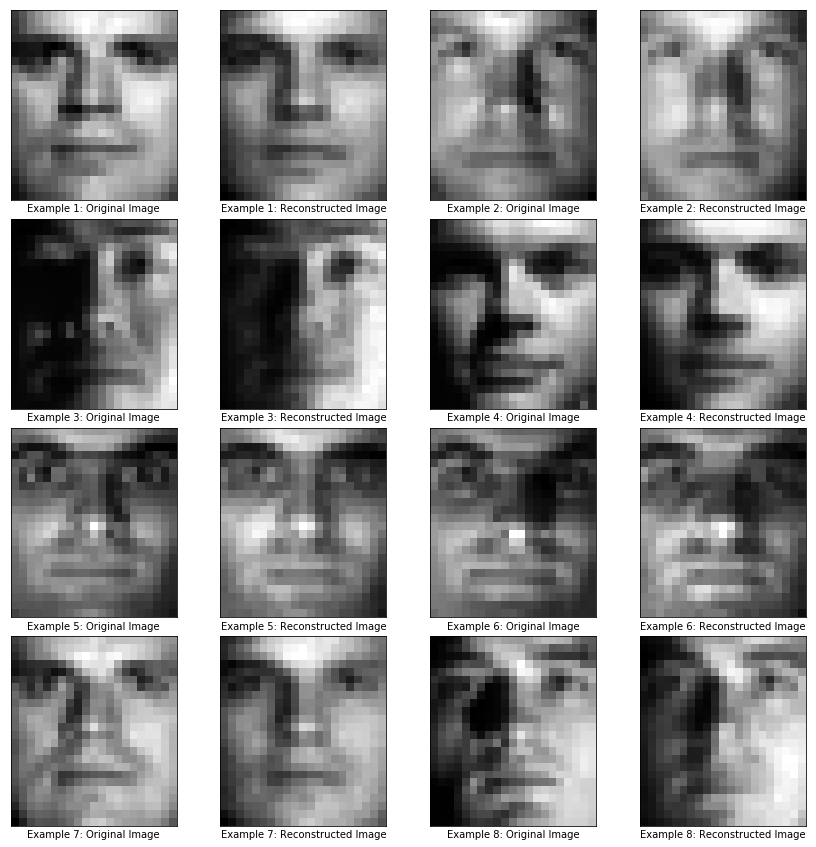

In [6]:
imgs_reconstructed = reconstruct_with_autoencoder(autoencoder,imgs,visual =True,height = height, width = width)

## Implement the Anomaly Detection 
### Split the data into the Training and Testing sets

In [7]:
# Split the images and labels
# By default: 80% in training and 20% in testing
train_ind, test_ind = split_training(labels)
x_train = imgs[train_ind,:]
x_test = imgs[test_ind,:]
x_train_reconstructed = imgs_reconstructed[train_ind,:]
x_test_reconstructed = imgs_reconstructed[test_ind,:]
labels_train = labels[train_ind]
labels_test = labels[test_ind]

### Method 1: Anomaly Detection with the Reconstruction Error

The higher the reconstruction error, the more likely the point will be an anomaly


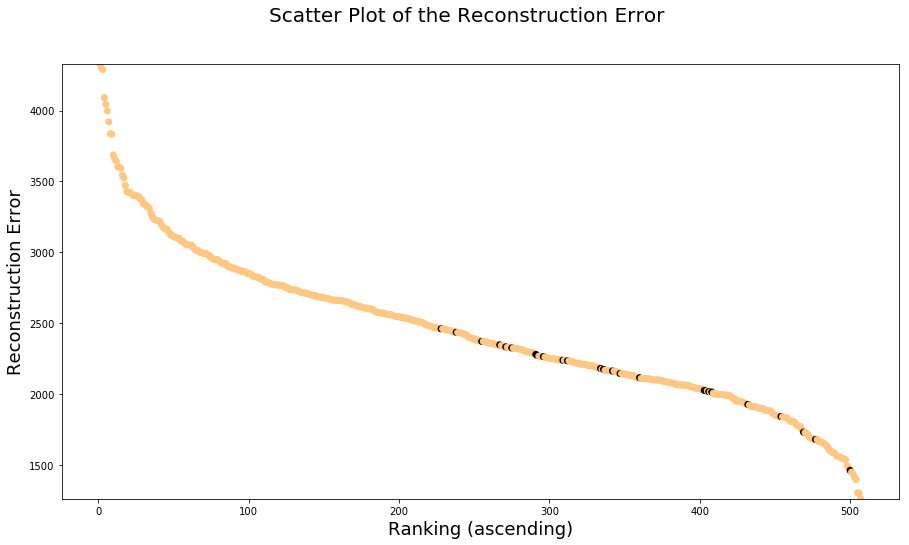

Training Results:
Precision: 5.0%
Recall: 96.0%
F-score: 9.5%
Precision@25: 0.0%

Testing Results:
Precision: 4.3%
Recall: 83.3%
F-score: 7.1%
Precision@6: 0.0%


In [8]:
train_test_with_reconstruction_error(x_train, x_train_reconstructed, x_test, x_test_reconstructed, labels_train, labels_test)

### Evaluate the Detector with the Testing Dataset

In [9]:
# Find the euclidean distance between the reconstructed dataset and the original ()
dist_test = find_euclidean_distance(reconst_test,np.transpose(x_test))

# Sort the Images and Labels based on the Probability
rank_test = np.argsort(-dist_test) # Sort from the Largest to the Smallest
dist_test_ranked = dist_test[rank_test] # Sort the distance
labels_test_ranked = labels_test[rank_test] # Rank Labels

# Give Predictions
preds = np.zeros(labels_test.shape) # Initialization
preds[dist_test_ranked > threshold_reconst_error] = 1

# Evaluate the Detector with Testing Data
eval_with_test(preds, labels_test_ranked, k = k)

NameError: name 'reconst_test' is not defined

### Method 2: Anomaly Detection with the Gaussian Distribution

#### Encode the images in the Training Set and the Testing Set

In [ ]:
# Pass the training data into the decoder model
encoded_train = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)

#### Visualize the Distribution of Data Points in the encoded matrix
To observe the scale and the Gaussian property 

In [ ]:
plot_matrix_data(encoded_train)

#### Fit a Gaussian Distribution Model with the Training Set

In [ ]:
# Get Gaussian Distribution Model for the Validation Data
# Note: fit_multivariate_gaussian() is my own coded function
dist_train = fit_multivariate_gaussian(encoded_train)

#### Visualize the Distribution of the Anomaly vs. Normal Set through Scatterplot

In [ ]:
# Get Probability of being Anomaly vs. being Normal
p_train = dist_train.pdf(encoded_train)   # Probability of Being Normal
# Plot the Probability with labels
plot_scatter_with_labels(p_train, labels_train,'Gaussian Probability')

In [ ]:
# Train the Anomaly Detector
threshold_gaussian  = select_threshold_probability(p_train, labels_train,k,to_print = True)

#### Apply to the testing set

In [ ]:
# Find the euclidean distance between the reconstructed dataset and the original ()
p_test = dist_train.pdf(encoded_test)   # Probability of Being Normal

# Sort the Images and Labels based on the Probability
rank_test = np.argsort(p_test) # Sort from the Smallest to the Largest
p_test_ranked = p_test[rank_test] # Sort the distance
labels_test_ranked = labels_test[rank_test] # Rank Labels

# Give Predictions
preds = np.zeros(labels_test.shape) # Initialization
preds[p_test_ranked < threshold_gaussian] = 1 # If the probability is smaller than the threshold, marked as anomaly

# Evaluate the Detector with Testing Data
eval_with_test(preds, labels_test_ranked, k = k)